**1. Imports**

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split

**2. Load Data**

In [2]:
orders = pd.read_csv("../data/raw/orders.csv")
op_train = pd.read_csv("../data/raw/order_products__train.csv")

user = pd.read_parquet("../data/features/user_features.parquet")
prod = pd.read_parquet("../data/features/product_features.parquet")
up = pd.read_parquet("../data/features/user_product_features.parquet")

*Load model:*

In [3]:
model = lgb.Booster(model_file="../models/lightgbm_reorder.txt")

**3. Prepare Validation Candidates**

*3.1 Filter validation orders*

In [4]:
orders_train = orders[orders["eval_set"] == "train"]

train_orders, val_orders = train_test_split(
    orders_train["order_id"].unique(),
    test_size=0.2,
    random_state=42
)

val_orders_user = orders_train[orders_train["order_id"].isin(val_orders)][["order_id", "user_id"]]
val_orders_user.head()


,order_id,user_id
10,1187899,1
78,880375,8
868,39325,55
923,1651215,59
988,2989905,63


*3.2 Build candidate pairs*

In [5]:
up_pairs = up[["user_id", "product_id"]]
val_candidates = val_orders_user.merge(up_pairs, on="user_id", how="left")

**4. Join Features**

In [6]:
X_val = (val_candidates
     .merge(user, on="user_id", how="left")
     .merge(prod, on="product_id", how="left")
     .merge(up, on=["user_id", "product_id"], how="left")
)


**5. Predict Probabilities**

In [7]:
# IDs you want to keep for grouping/inspection
id_cols = ["order_id", "user_id", "product_id", "product_name"]

# Always use the model's expected features (names + order)
feature_cols = model.feature_name()

# If you want to fail fast when something is missing:
missing = set(feature_cols) - set(X_val.columns)
assert not missing, f"X_val is missing model features: {missing}"

# Predict
X_val["pred_prob"] = model.predict(X_val[feature_cols], validate_features=True)


In [ ]:
# drop_cols = ["order_id", "user_id", "product_id"]
# feature_cols = [c for c in X_val.columns if c not in drop_cols]

# X_val["pred_prob"] = model.predict(X_val[feature_cols])


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: product_name: object

**6. Build Predicted Baskets**

In [8]:
def predict_basket(df, prob_col="pred_prob", threshold=0.2, k=10):
    df = df.sort_values(prob_col, ascending=False)
    selected = df[df[prob_col] >= threshold]
    if selected.empty:
        selected = df.head(k)
    return selected["product_id"].tolist()

pred_baskets = (X_val
    .groupby("order_id")
    .apply(predict_basket, include_groups=False)  
)



**7. Ground Truth Baskets**

In [9]:
true_baskets = (op_train[op_train["order_id"].isin(val_orders)]
    .groupby("order_id")["product_id"]
    .apply(list)
)

*Align:*

In [10]:
pred_baskets = pred_baskets.reindex(true_baskets.index)

**8. Evaluate – Precision@k, Recall@k, F1**

In [11]:
def prf(y_true, y_pred):
    t = set(y_true)
    p = set(y_pred)
    tp = len(t & p)
    if tp == 0:
        return 0, 0, 0
    precision = tp / len(p)
    recall = tp / len(t)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, f1

metrics = pred_baskets.index.to_series().apply(
    lambda oid: prf(true_baskets[oid], pred_baskets[oid])
)

precision_mean = metrics.apply(lambda x: x[0]).mean()
recall_mean = metrics.apply(lambda x: x[1]).mean()
f1_mean = metrics.apply(lambda x: x[2]).mean()

precision_mean, recall_mean, f1_mean


(np.float64(0.34521593274922713),
 np.float64(0.3343529857680471),
 np.float64(0.3026220458273255))

**9. Business Lift Analysis**

*Compare with a baseline recommender:*

In [12]:
# baseline - most frequently purchased products by each user historically
baseline_preds = (
    up.sort_values(["user_id","up_order_count"], ascending=False)
      .groupby("user_id")
      .head(10)
      .groupby("user_id")["product_id"]
      .apply(list)
)


In [13]:
baseline_preds

user_id
1         [196, 12427, 10258, 25133, 13032, 46149, 13176...
2         [32792, 47209, 24852, 1559, 18523, 19156, 1200...
3         [39190, 47766, 21903, 9387, 17668, 18599, 4396...
4         [35469, 1200, 2707, 7160, 7350, 11865, 17769, ...
5         [11777, 26604, 24535, 43693, 8518, 13988, 2141...
                                ...                        
206205    [27845, 3896, 21137, 22035, 38739, 39160, 4335...
206206    [38530, 47011, 11520, 27086, 40124, 11954, 130...
206207    [44632, 3397, 13176, 36011, 33787, 39180, 2796...
206208    [34213, 13176, 33000, 18770, 23579, 27845, 211...
206209    [6846, 9405, 41213, 13176, 19348, 23594, 24852...
Name: product_id, Length: 206209, dtype: object

*Baseline function*

In [14]:
def evaluate_baseline(up, val_orders_user, true_baskets, k=10):
    
    baseline_preds = (
        up.sort_values(["user_id", "up_order_count"], ascending=False)
          .groupby("user_id")
          .head(k)
          .groupby("user_id")["product_id"]
          .apply(list)
    )
    
    val_user_ids = val_orders_user["user_id"].unique()
    baseline_preds_val = baseline_preds.loc[
        baseline_preds.index.isin(val_user_ids)
    ]

    true_baskets_user = (
        val_orders_user
        .merge(true_baskets.rename("true_basket"), on="order_id")
        .set_index("user_id")["true_basket"]
    )

    eval_df = (
        true_baskets_user
        .to_frame()
        .join(baseline_preds_val.rename("pred_basket"))
        .dropna()
    )


    def prf(true_list, pred_list):
        t = set(true_list)
        p = set(pred_list)
        tp = len(t & p)
        if tp == 0:
            return 0, 0, 0
        precision = tp / len(p)
        recall = tp / len(t)
        f1 = 2 * precision * recall / (precision + recall)
        return precision, recall, f1

    
    eval_df["precision"] = eval_df.apply(
        lambda x: prf(x.true_basket, x.pred_basket)[0], axis=1
    )
    eval_df["recall"] = eval_df.apply(
        lambda x: prf(x.true_basket, x.pred_basket)[1], axis=1
    )
    eval_df["f1"] = eval_df.apply(
        lambda x: prf(x.true_basket, x.pred_basket)[2], axis=1
    )

    baseline_precision = eval_df["precision"].mean()
    baseline_recall = eval_df["recall"].mean()
    baseline_f1 = eval_df["f1"].mean()

    return {
        "baseline_precision": baseline_precision,
        "baseline_recall": baseline_recall,
        "baseline_f1": baseline_f1,
        "baseline_df": eval_df
    }


*1. Call it after you compute true_baskets and val_orders_user:*

In [15]:
baseline_results = evaluate_baseline(
    up=up, 
    val_orders_user=val_orders_user,
    true_baskets=true_baskets,
    k=10
)


*Results:*

In [17]:
print("Baseline Precision:", baseline_results["baseline_precision"])
print("Baseline Recall:", baseline_results["baseline_recall"])
print("Baseline F1:", baseline_results["baseline_f1"])

print("Model Precision:", precision_mean)
print("Model Recall:", recall_mean)
print("Model F1:", f1_mean)

Baseline Precision: 0.27379225475216634
Baseline Recall: 0.31726632428682217
Baseline F1: 0.25689448398380593
Model Precision: 0.34521593274922713
Model Recall: 0.3343529857680471
Model F1: 0.3026220458273255


**10. SHAP / Feature Importance**

c:\Consulting Startup and Career Journey\Marketing Analytics\NOPM using LightGBM\Next-Order-Purchase-Prediction-Model-using-LightGBM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Consulting Startup and Career Journey\Marketing Analytics\NOPM using LightGBM\Next-Order-Purchase-Prediction-Model-using-LightGBM\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


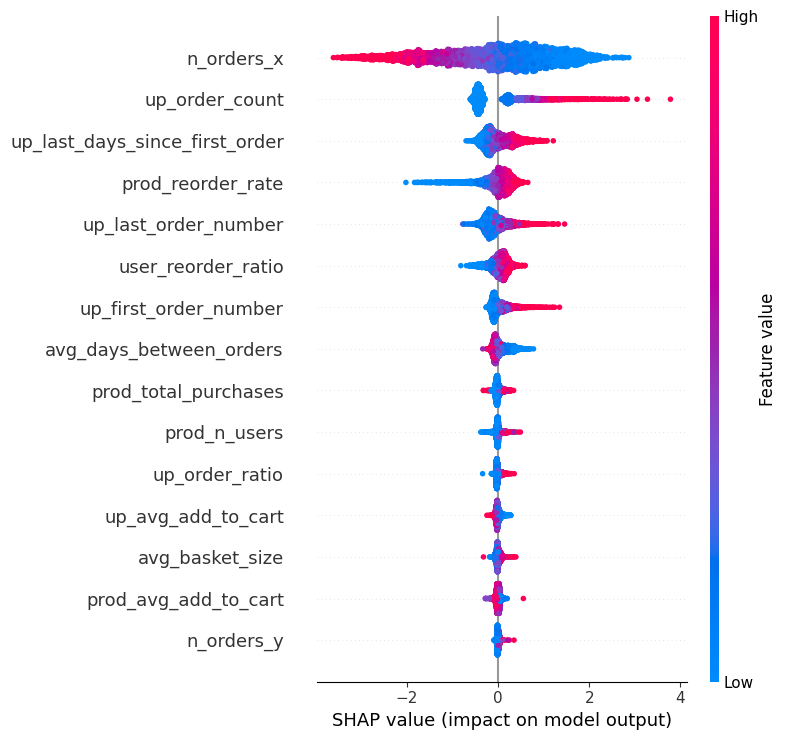

In [18]:
import shap

explainer = shap.TreeExplainer(model)
sample = X_val[feature_cols].sample(5000)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample)


**11. Segment Users & Analyze Behavior**

In [19]:
user["segment"] = pd.cut(
    user["user_reorder_ratio"],
    bins=[0,0.3,0.7,1.0],
    labels=["low","medium","high"]
)

user.head()


,user_id,n_orders,avg_days_between_orders,avg_basket_size,user_reorder_ratio,segment
0,1,10,19.555556,5.900000,0.694915,medium
1,2,14,15.230769,13.928571,0.476923,medium
2,3,12,12.090909,7.333333,0.625000,medium
3,4,5,13.750000,3.600000,0.055556,low
4,5,4,13.333333,9.250000,0.378378,medium


Compare metrics per segment.

**12. Save Evaluation Outputs**

In [20]:
pred_baskets.to_json("../artifacts/predicted_baskets.json")
true_baskets.to_json("../artifacts/true_baskets.json")

pd.DataFrame({
    "precision": [precision_mean],
    "recall": [recall_mean],
    "f1": [f1_mean]
}).to_csv("../artifacts/metrics.csv", index=False)
